<a href="https://colab.research.google.com/github/CepbluKot/ecology_ml/blob/main/ecology_ml_w_data_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [274]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('data.csv')
df=df.drop(['X','Y','ObjectID','code', 'area', 'ID', 'texture', 'parentrock', 'relief', 'soil_name', 'Al ммоль-экв/100г'], axis=1)
df.head(5)

,pHH20,pHKCl,Гумус %,P мг/кг,K мг/кг,Mn мг/кг,Co мг/кг,Cu мг/кг,Zn мг/кг,Mo мг/кг,B мг/кг,Ca ммоль-экв/100г,Mg ммоль-экв/100г,N_NH4 мг/кг,N_NO3 мг/кг,Z,NDVI
0,5.8,5.0,6.5,81.1,178.3,24.1,0.04,0.06,0.21,0.0,2.2,13.7,2.7,8.9,40.8,1.706668,0.727741
1,5.9,5.1,6.2,262.9,328.8,29.0,0.04,0.07,0.18,0.0,2.6,14.3,2.6,12.1,43.4,1.811376,0.658671
2,5.7,4.9,7.4,202.3,255.5,27.9,0.04,0.10,0.25,0.0,2.1,12.5,2.5,9.0,24.3,1.891337,0.768856
3,5.9,5.0,7.2,66.7,136.8,15.1,0.03,0.10,0.37,0.0,2.3,14.4,2.7,9.1,21.8,1.919135,0.722283
4,5.7,5.0,6.7,68.0,210.7,22.9,0.04,0.06,0.22,0.0,2.0,12.5,2.3,8.2,24.1,1.609458,0.700665


<AxesSubplot: >

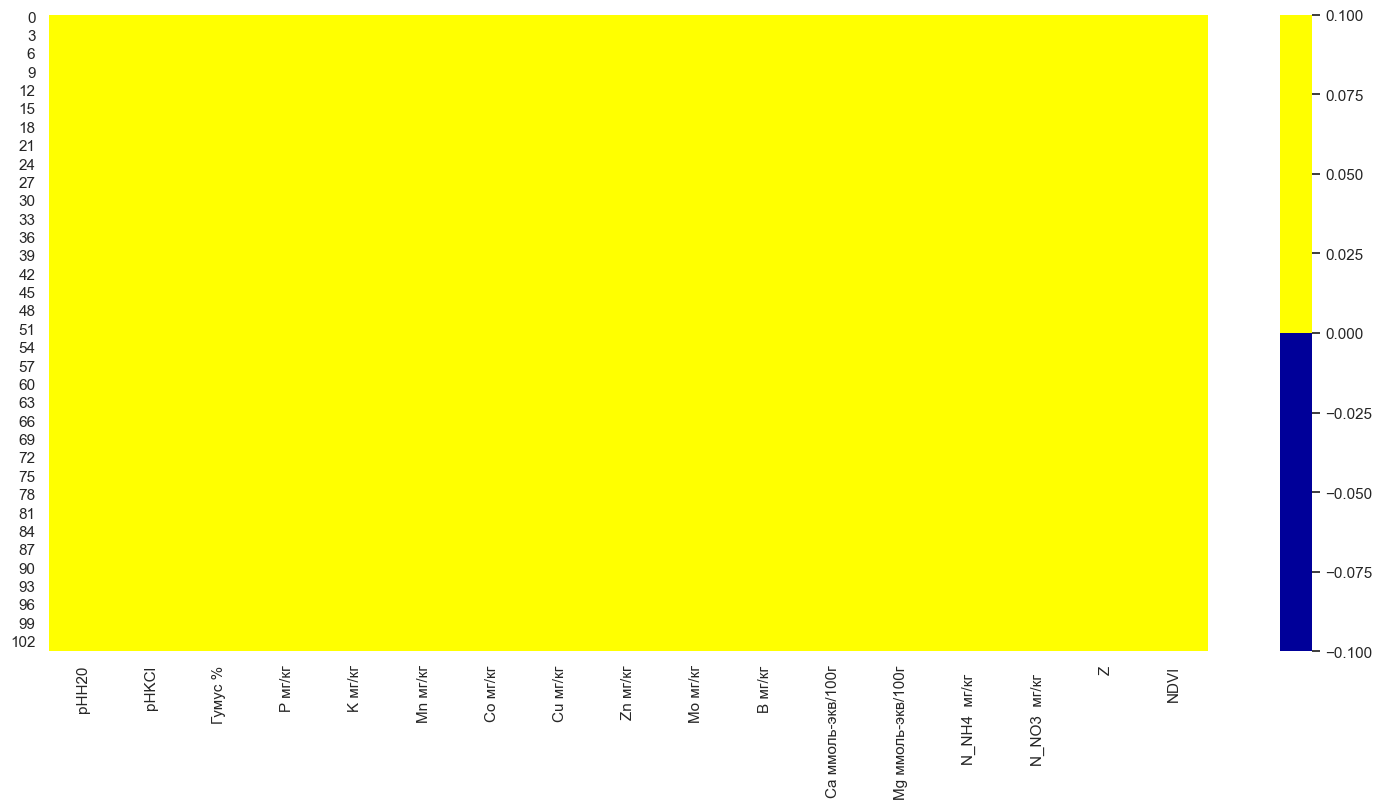

In [275]:
colours = ['#000099', '#ffff00'] 
sns.heatmap(df.isnull(), cmap=sns.color_palette(colours))

In [276]:
df = df.drop_duplicates()


print(df.shape)
print(df_dedupped.shape)

(104, 17)
(104, 17)


In [277]:
X=df.drop('NDVI',axis=1)
y=df['NDVI']

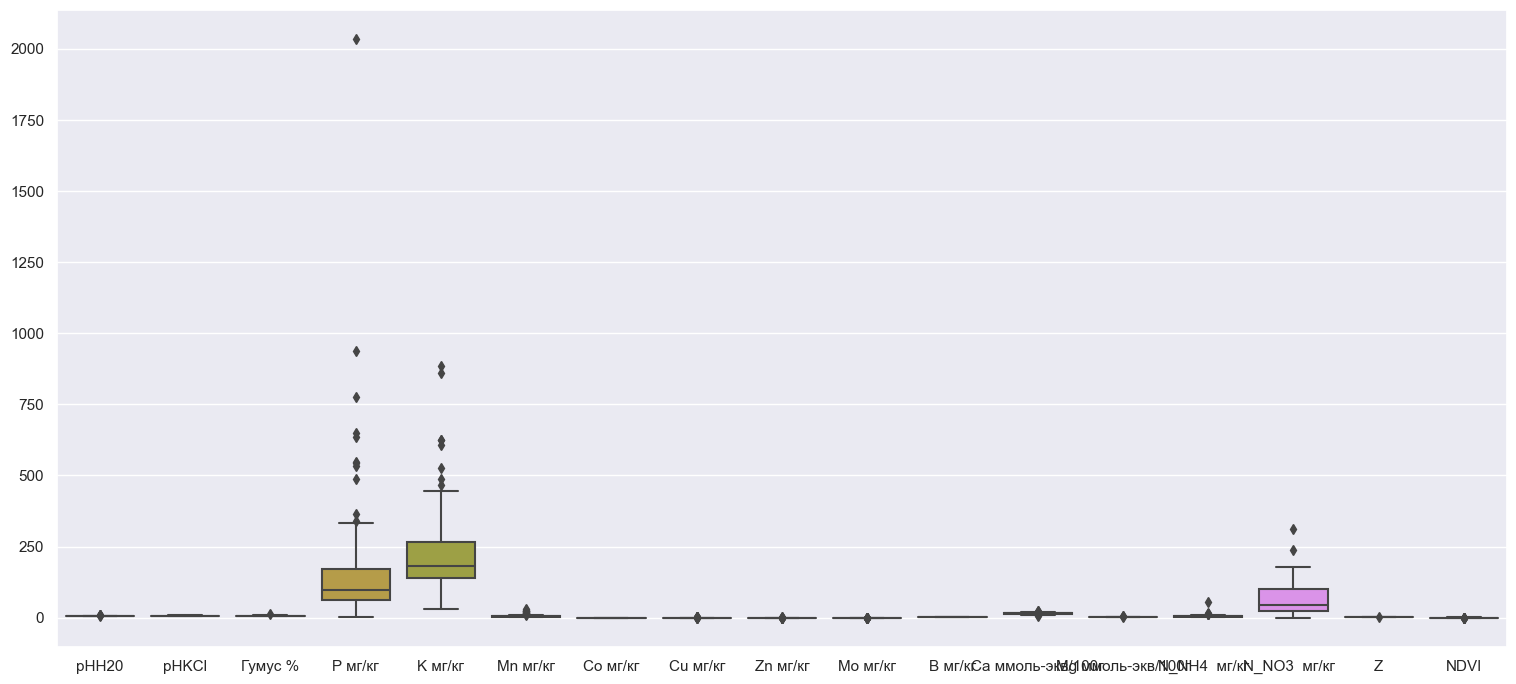

In [278]:
import seaborn as sns


sns.set(rc={'figure.figsize':(18.7,8.27)})
ax = sns.boxplot(df)  

In [279]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import IsolationForest


iso = IsolationForest()
y_outliers = iso.fit_predict(df)

for i in range(len(y_outliers)):
    if y_outliers[i] == -1:
        df.drop(i, inplace = True)

<AxesSubplot: >

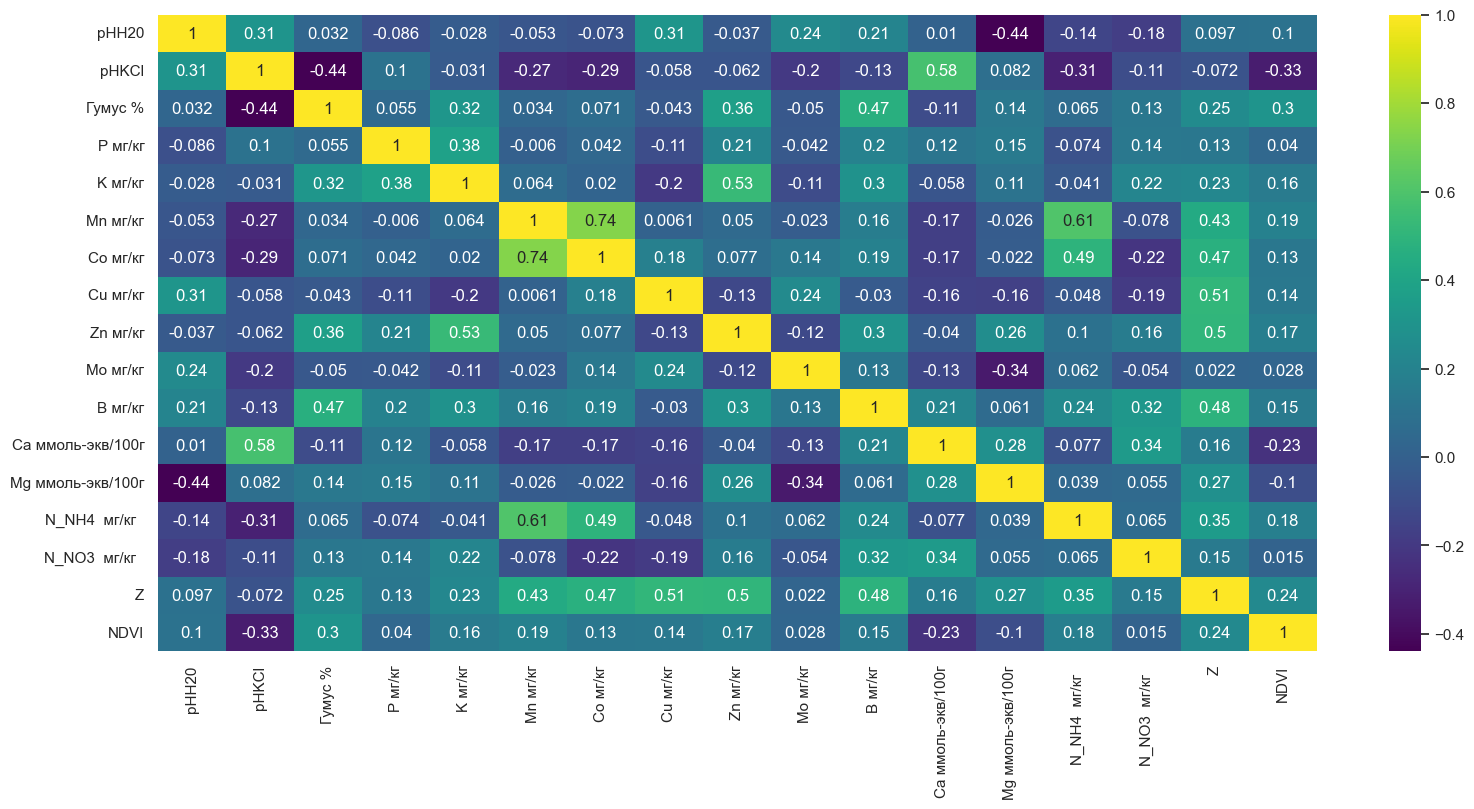

In [280]:
sns.heatmap(df.corr(),  cmap = 'viridis',annot = True)

In [281]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

In [282]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression


best_parameters_selector = SelectKBest(score_func=f_regression, k=9)

selected_parameters_data = best_parameters_selector.fit_transform(X_norm, y)

filter = best_parameters_selector.get_support()
features = X.columns

select_k_best_features = features[filter]

dict_keys(['pHKCl', 'Zn мг/кг', 'Mn мг/кг', 'Ca ммоль-экв/100г', 'pHH20', 'Гумус %', 'Mg ммоль-экв/100г', 'N_NO3  мг/кг  ', 'P мг/кг'])


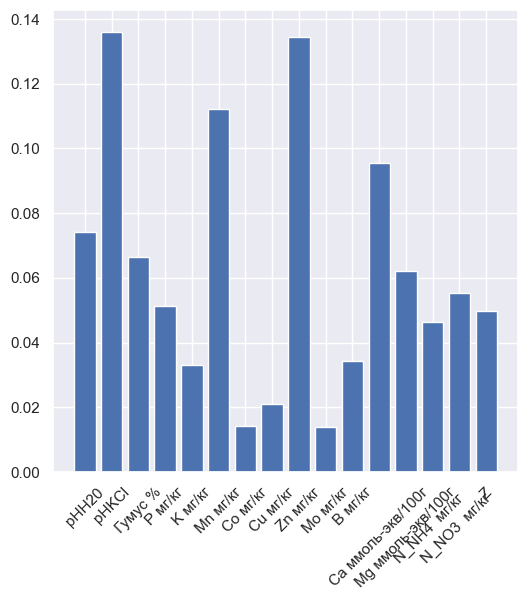

In [283]:
from sklearn.ensemble import RandomForestRegressor


regr = RandomForestRegressor()
regr.fit(X_norm, y)
plt.figure(figsize=(6,6))
plt.bar(X.columns, regr.feature_importances_)
plt.xticks(rotation=45)


random_forest_features = {}
for id in range(len(X.columns)):
  random_forest_features[X.columns[id]] = regr.feature_importances_[id]


random_forest_features = dict(sorted(random_forest_features.items(), key=lambda item: item[1], reverse=True)[:9]).keys()
print(random_forest_features)

In [284]:
from sklearn.feature_selection import RFE


rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=9)
rfe_res = rfe.fit_transform(X_norm, y)


filter = rfe.get_support()
features = X.columns


rfe_features = features.values[filter]

In [285]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [286]:
X=df.drop('NDVI',axis=1)
Y=df['NDVI']
X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size = 0.20, shuffle = True)

In [287]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression()
LR.fit(X_train, Y_train)				#Обучаем модель
Y_LR = LR.predict(X_test)				#Предсказываем значения для выборки    

print('fakescore', LR.score(X_train, Y_train))


print ('MAE:', round (mean_absolute_error(Y_test, Y_LR),3))		#Метрики
print ('√MSE:', round (mean_squared_error(Y_test, Y_LR)**(1/2),3))
print ('R2_score:', round (r2_score(Y_test, Y_LR),3))

fakescore 0.24300226987921458
MAE: 0.09
√MSE: 0.12
R2_score: 0.119


делаем вывод, что модель типа DecisionTreeRegressor не подходит тк пропорциональное ее размеру увеличивается ошибка